# Cutting.ipynb
Author: Yueqian Lin

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline   
import scipy.ndimage
import cv2
import xml.dom.minidom
from PIL import Image
import numpy as np
import os, glob
import tensorflow as tf
from tensorflow import keras

In [ ]:
# in case you can't import cv2
pip install opencv-python
# in case you can't import skimage
pip install scikit-image

     |████████████████████████████████| 60.4 MB 38.8 MB/s eta 0:00:01     |████████████████████▍           | 38.6 MB 38.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
def readxml(path):
    dom = xml.dom.minidom.parse(path)
    root = dom.documentElement
    nas = ['xmin', 'xmax', 'ymin', 'ymax']
    objects = root.getElementsByTagName("object")
    datas = []
    for i in range(len(objects)):
        bnd = objects[i].getElementsByTagName("bndbox")[0]
        datas.append([0, 0, 0, 0])
        for ele in bnd.childNodes:
            try:
                na = ele.tagName
            except:
                continue
            for j in range(len(nas)):
                if nas[j] == na:
                    datas[i][j] = int(ele.firstChild.data)
    if len(datas) == 1:
        datas.pop()
    objects = root.getElementsByTagName("item")
    for i in range(len(objects)):
        bnd = objects[i].getElementsByTagName("bndbox")[0]
        datas.append([0, 0, 0, 0])
        for ele in bnd.childNodes:
            try:
                na = ele.tagName
            except:
                continue
            for j in range(len(nas)):
                if nas[j] == na:
                    datas[i][j] = int(ele.firstChild.data)
    return datas
def tis(x):
    if x < 0:
        return 0
    if x > gap:
        return gap
    return x
from PIL import Image
import numpy as np
import os, glob
# import tensorflow as tf
# from tensorflow import keras

X_full = []
Y_full = []
X_sp = []
Y_sp = []
now = 0

def get_real_pos(n, x, y, k):
    if k == 0:
        return (x, y)
    if k == -1:
        return (n - y, x)
    if k == 2 or k == -2:
        return (n - x, n - y)
    if k == 1:
        return (y, n - x)

def get_real_pos2(n, a, k):
    if k == 0:
        return a
    if k == -1:
        return [n - a[3], n - a[2], a[0], a[1]]
    if k == 2 or k == -2:
        return [n - a[1], n - a[0], n - a[3], n - a[2]]
    if k == 1:
        return [a[2], a[3], n - a[1], n - a[0]]

def get_real_pos3(n, m, a, k):
    if k == 0:
        return a
    if k == -1:
        return [n - a[3], n - a[2], a[0], a[1]]
    if k == 2 or k == -2:
        return [m - a[1], m - a[0], n - a[3], n - a[2]]
    if k == 1:
        return [a[2], a[3], m - a[1], m - a[0]]
import numpy as np
def flip180(arr):
    new_arr = arr.reshape(arr.size)
    new_arr = new_arr[::-1]
    new_arr = new_arr.reshape(arr.shape)
    return new_arr
def flip90_left(arr):
    new_arr = np.transpose(arr)
    new_arr = new_arr[::-1]
    return new_arr
def flip90_right(arr):
    new_arr = arr.reshape(arr.size)
    new_arr = new_arr[::-1]
    new_arr = new_arr.reshape(arr.shape)
    new_arr = np.transpose(new_arr)[::-1]
    return new_arr
def get_real_img(arr, k):
    if k == 0:
        return arr
    if k == -1:
        return flip90_right(arr)
    if k == 2 or k == -2:
        return flip180(arr)
    if k == 1:
        return flip90_left(arr)

def get_real_img2(arr, k):
    img = Image.fromarray(np.uint8(arr))
    if k == 0:
        return np.asarray(img)
    if k == -1:
        return np.asarray(img.transpose(Image.ROTATE_270))
    if k == 2 or k == -2:
        return np.asarray(img.transpose(Image.ROTATE_180))
    if k == 1:
        return np.asarray(img.transpose(Image.ROTATE_90))

def get_areas(box):
    return (box[1] - box[0]) * (box[3] - box[2])


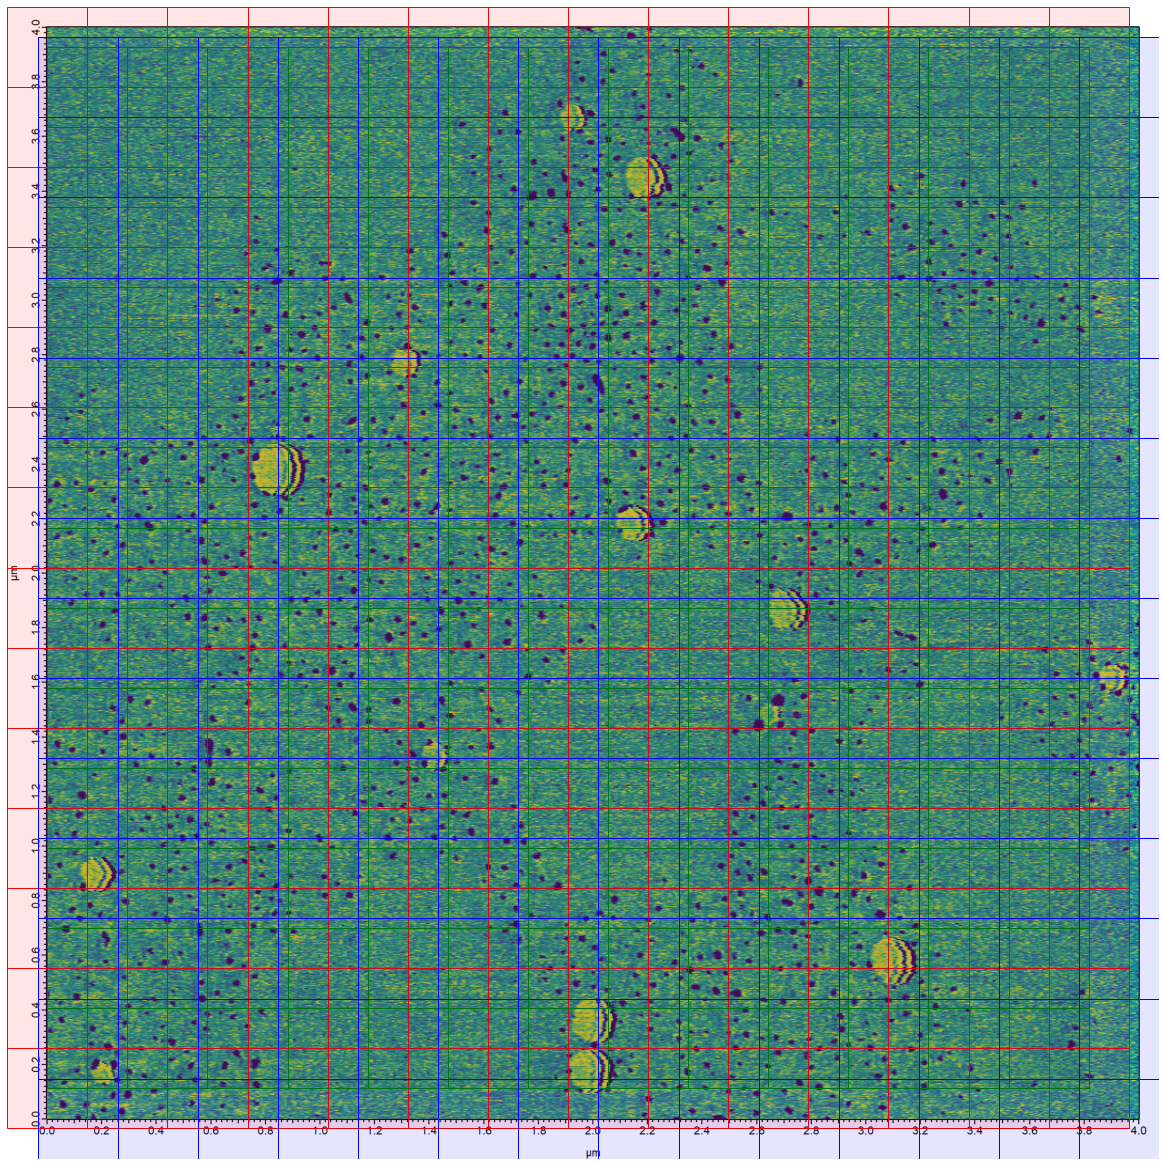

In [4]:
# this is used to find the suitable gap
filename = '/home/yl768/UVM_H/images/46k_105C/labeled/X105C0030PhRm0.tif'
im = np.asarray(Image.open(filename))
xn, yn,z = im.shape
gap=150
plt.figure(figsize=(20, 16))
plt.imshow(im)
ap = plt.gca()
plt.axis('off')
for i in range(0, xn, gap):
    for j in range(0, yn, gap):
        if (i + gap < xn) and (j + gap < yn):
            rect = patches.Rectangle((j - 0.5, i - 0.5), gap, gap, linewidth = 1, edgecolor = 'r', facecolor = "none")
            ap.add_patch(rect)
            rect = patches.Rectangle((j - 0.5, i - 0.5), gap, gap, color = "r", alpha = 0.1)
            ap.add_patch(rect)
for i in range(int(gap / 2), xn, gap):
    for j in range(int(gap / 2), yn, gap):
        if (i + gap < xn) and (j + gap < yn):
            rect = patches.Rectangle((j - 0.5, i - 0.5), gap, gap, linewidth = 1, edgecolor = 'g', facecolor = "none")
            ap.add_patch(rect)
            rect = patches.Rectangle((j - 0.5, i - 0.5), gap, gap, color = "g", alpha = 0.1)
            ap.add_patch(rect)
for i in range(xn, 0, -gap):
    for j in range(yn, 0, -gap):
        if (i - gap > 0) and (j - gap > 0):
            rect = patches.Rectangle((j - 0.5 - gap, i - 0.5 - gap), gap, gap, linewidth = 1, edgecolor = 'b', facecolor = "none")
            ap.add_patch(rect)
            rect = patches.Rectangle((j - 0.5 - gap, i - 0.5 - gap), gap, gap, color = "b", alpha = 0.1)
            ap.add_patch(rect)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.savefig("ex.png", dpi = 300)

In [37]:
import cv2
import time
import random
import os
import math
import numpy as np
from skimage.util import random_noise
from skimage import exposure
# noise
def _addNoise(img):
        return random_noise(img, mode='gaussian', clip=True) * 255

# brightness
def _changeLight(img):
    # random.seed(int(time.time()))
    flag = random.uniform(0.5, 1.5)  # flag>1为调暗,小于1为调亮
    return exposure.adjust_gamma(img, flag)

# rotation
def _rotate_img_bbox(img, bboxes, angle=5, scale=1.):
    w = img.shape[1]
    h = img.shape[0]
    rangle = np.deg2rad(angle)  # angle in radians
    # now calculate new image width and height
    nw = (abs(np.sin(rangle) * h) + abs(np.cos(rangle) * w)) * scale
    nh = (abs(np.cos(rangle) * h) + abs(np.sin(rangle) * w)) * scale
    # ask OpenCV for the rotation matrix
    rot_mat = cv2.getRotationMatrix2D((nw * 0.5, nh * 0.5), angle, scale)
    # calculate the move from the old center to the new center combined
    # with the rotation
    rot_move = np.dot(rot_mat, np.array([(nw - w) * 0.5, (nh - h) * 0.5, 0]))
    # the move only affects the translation, so update the translation
    # part of the transform
    rot_mat[0, 2] += rot_move[0]
    rot_mat[1, 2] += rot_move[1]
    rot_img = cv2.warpAffine(img, rot_mat, (int(math.ceil(nw)), int(math.ceil(nh))), flags=cv2.INTER_LANCZOS4)
    rot_bboxes = list()
    for bbox in bboxes:
        xmin = bbox[0]
        ymin = bbox[2]
        xmax = bbox[1]
        ymax = bbox[3]
        point1 = np.dot(rot_mat, np.array([(xmin + xmax) / 2, ymin, 1]))
        point2 = np.dot(rot_mat, np.array([xmax, (ymin + ymax) / 2, 1]))
        point3 = np.dot(rot_mat, np.array([(xmin + xmax) / 2, ymax, 1]))
        point4 = np.dot(rot_mat, np.array([xmin, (ymin + ymax) / 2, 1]))
        concat = np.vstack((point1, point2, point3, point4))
        concat = concat.astype(np.int32)
        rx, ry, rw, rh = cv2.boundingRect(concat)
        rx_min = rx
        ry_min = ry
        rx_max = rx + rw
        ry_max = ry + rh
        rot_bboxes.append([rx_min, rx_max, ry_min, ry_max])

    return rot_img, rot_bboxes

# flip
def _filp_pic_bboxes(img, bboxes):
    import copy
    flip_img = copy.deepcopy(img)
    h, w, _ = img.shape
    flip_img = cv2.flip(flip_img, 1)  
    flip_bboxes = list()
    for box in bboxes:
        x_min = box[0]
        y_min = box[2]
        x_max = box[1]
        y_max = box[3]
        flip_bboxes.append([w - x_max, w - x_min,y_min, y_max])
        

    return flip_img, flip_bboxes

In [25]:
img=np.asarray(Image.open(filename))
h, w, _ = img.shape
h
tmp1, tmp2 =_filp_pic_bboxes(img,[[0,1,2,3]])
tmp2
newpoi[4]

[[2, 243, 67, 300]]

Max particle in the section:14
Avg particle in the section:5.520833333333333

Max particle in the section:22
Avg particle in the section:5.875

Max particle in the section:12
Avg particle in the section:4.645833333333333

Max particle in the section:17
Avg particle in the section:5.428571428571429



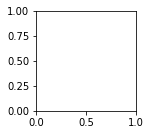

In [39]:
path="/home/yl768/UVM_H/images/100k_95C/"
# path="/home/yl768/UVM_H/images/46k_105C/"
f1= open(path+"label.txt", "w") #You need to create this txt file at first in your directory, also ./datas/ folder is needed
tots = 0
cnts = 0
now = 0
for filename in glob.glob(path+"labeled/*.tif"):
    datas=readxml(filename[:-3]+'xml')
#     for o in range(4):
        #nam = filename[18:30] #find the position of the file, this is not elegant...
#             datas = readxml("./UVM/outputs/" + nam + ".xml") 
        #datas=readxml("/home/eric/jupyter/env_jupyter/projects/ObjectDetection/46k_105C/X105C0030PhRm0.xml")
    o=0
    k=0
    im = np.asarray(Image.open(filename))
    xn, yn,z = im.shape
    poi = []
    ims = []
    newpoi = []
    imgpos = []
    gap = 300
    maxs = 0
    avg = 0
    cnt = 0
    avg_area = 0
    for box in datas:
        avg_area += get_areas(box)
    avg_area /= len(datas)
    for i in range(0, xn, gap):
        for j in range(0, yn, gap):
        #                 for k in range(-1, 3): # rotate
#             for k in range(0, 2):
#                 k = o - 1
#                 if k == 1:
#                     tm = np.random.randint(1, 4)
#                     if tm != 1:
#                         continue
#                     while k == o-1:
#                         k = np.random.randint(-1, 3)
            if (i + gap < xn) and (j + gap < yn):
                tmp_im=get_real_img2(np.asarray(im[i : i + gap, j : j + gap]), k)
                ims.append(tmp_im)
                imgpos.append((int(i / gap), int(j / gap)))
                poi.append([])
                newpoi.append([])
                tmp = 0

                tmp_poi=len(newpoi) - 1
                for l in datas:
                    if ((l[0] > j and l[0] < j + gap) or (l[1] > j and l[1] < j + gap) or 
                        (l[2] > i and l[3] < i + gap) or (l[3] > i and l[3] < i + gap)):
                        lp = [tis(l[0] - j), tis(l[1] - j), tis(l[2] - i), tis(l[3] - i)]
                        if lp[0] == lp[1] or lp[2] == lp[3]:
                            continue
                        if get_areas(lp) <= avg_area / 10:
                            continue
                        newpoi[tmp_poi].append(get_real_pos2(gap, lp, k))
                        tmp += 1

                maxs = max(maxs, tmp)
                if tmp != 0:
                    avg += tmp
                    cnt += 1
#             data augmentation here
                if len(newpoi[tmp_poi]) != 0:

                    ims.append(_changeLight(tmp_im))
                    newpoi.append(newpoi[tmp_poi])
                    ims.append(_addNoise(tmp_im))
                    newpoi.append(newpoi[tmp_poi])
                    tmp1, tmp2 =_rotate_img_bbox(tmp_im,newpoi[tmp_poi],90)
                    ims.append(tmp1)
                    newpoi.append(tmp2)
                    tmp1, tmp2 =_rotate_img_bbox(tmp_im,newpoi[tmp_poi],180)
                    ims.append(tmp1)
                    newpoi.append(tmp2)
                    tmp1, tmp2 =_rotate_img_bbox(tmp_im,newpoi[tmp_poi],270)
                    ims.append(tmp1)
                    newpoi.append(tmp2)
                    tmp1, tmp2 =_filp_pic_bboxes(tmp_im,newpoi[tmp_poi])
                    ims.append(tmp1)
                    newpoi.append(tmp2)
                    
    print("Max particle in the section:" + str(maxs))
    print("Avg particle in the section:" + str(avg / cnt))
    print("")
    tots += avg / cnt
    cnts += 1
    #print('number of frames:', len(ims))
    for k in range(len(ims)):
        if len(newpoi[k]) == 0:
            continue
#         print(ims)
        p = ims[k].astype('int')
        plt.imshow(p)
        plt.axis('off')
        fig = plt.gcf()
        fig.set_size_inches(4.16/3,4.16/3) #dpi = 300, output = 416*416 pixels
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
#           save the figure into directory, create the folder in advance
        fig.savefig(path+'datas/' + (('0' + str(now)) if now < 10 else str(now)) + '.png', transparent=True, dpi=300, pad_inches = 0)
        plt.cla()
        sw = path+'datas/' + (('0' + str(now)) if now < 10 else str(now)) + '.png '
        lx = 416 / gap
        for ls in newpoi[k]:
            sw += str(int(ls[0] * lx))+','+str(int(ls[2] * lx))+','+str(int(ls[1] * lx))+','+str(int(ls[3] * lx))+',0 '
        f1.write(sw + '\n')
        now += 1


   